# Supplementary figure (Time-sensitive VAE)

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])

## Imports

In [3]:
# general
import sys
import os
from functools import partial

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import patac as pa

In [5]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# local
sys.path.append('..')
from utils import settings

## Plot settings

In [7]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
sns.set_style("ticks")

In [8]:
FIGURE_NUMBER = 'supp23'
PANEL_COUNTS = 1

def save_panel(fig):
    global PANEL_COUNTS
    
    fig_dir = 'figures/fig%s' % FIGURE_NUMBER
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(fig_dir + '/panel_%d.svg' % PANEL_COUNTS, dpi=350)
    PANEL_COUNTS += 1

## Plot embedding

In [9]:
adata = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed_tmp.h5ad'))

In [10]:
df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
df['exp_id'] = adata.obs['exp_id']
df['timepoint'] = adata.obs['timepoint']
df['time_vae'] = adata.obs['time_vae']    
df['leiden_vae'] = adata.obs['leiden_vae']

In [11]:
cluster_medians = df.groupby('leiden_vae')[['UMAP1', 'UMAP2']].median()

In [12]:
clusters = df['leiden_vae'].cat.categories.tolist()

In [13]:
leiden_colors = pd.Series(dict(zip(adata.obs['leiden_vae'].cat.categories, adata.uns['leiden_vae_colors'])))

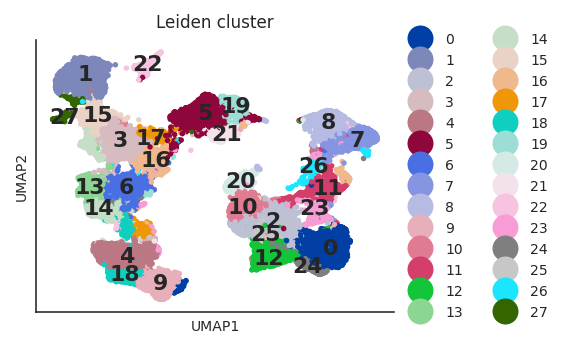

In [14]:
fig, ax = plt.subplots(figsize=(3.2, 2.5))
p = ax.scatter(
    x='UMAP1', y='UMAP2',
    c=leiden_colors[df['leiden_vae']], 
    rasterized=True,
    data=df,
    s=3)

labels = clusters
handles = [plt.Line2D([],[], color=leiden_colors[i], ls="",marker="o") for i in labels]

plt.legend(
    handles=handles,
    labels=labels, 
    markerscale=2, 
    ncol=2,
    loc='center left',
    bbox_to_anchor=(1, .5), 
    frameon=False)

for i in cluster_medians.index:
    ax.annotate(i, cluster_medians.loc[i], va='center', ha='center', fontsize=11, weight='bold')
ax.set(xlabel='UMAP1', ylabel='UMAP2', xticks=[], yticks=[], title='Leiden cluster')
sns.despine()

save_panel(fig)

In [15]:
adata = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))

In [16]:
df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
df['exp_id'] = adata.obs['exp_id']
df['timepoint'] = adata.obs['timepoint']
df['time_vae'] = adata.obs['time_vae']    
df['leiden_vae'] = adata.obs['leiden_vae']

In [17]:
timepoint_colors = pd.Series(dict(zip(adata.obs['timepoint'].cat.categories, adata.uns['timepoint_colors'])))
exp_id_colors = pd.Series(dict(zip(adata.obs['exp_id'].cat.categories, adata.uns['exp_id_colors'])))

In [18]:
F1_IDS = 'F1-' + pd.read_csv(settings.EXPERIMENT_INFO, sep='\t', index_col=0)['paternal_id']

In [19]:
timepoints = df['timepoint'].cat.categories.tolist()
exp_ids = df['exp_id'].cat.categories.tolist()

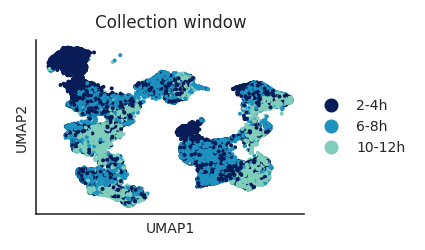

In [20]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
p = ax.scatter(
    x='UMAP1', 
    y='UMAP2', 
    c=timepoint_colors[df['timepoint']], 
    data=df, s=1,
    rasterized=True)

labels = timepoints
handles = [plt.Line2D([],[], color=timepoint_colors[i], ls="",marker="o") for i in labels]
labels=[x.replace('to', '-') + 'h' for x in labels]

plt.legend(
    handles=handles,
    labels=labels, 
    markerscale=1, 
    loc='center left',
    bbox_to_anchor=(1, .5), 
    frameon=False)
fig.add_axes()
ax.set(xlabel='UMAP1', ylabel='UMAP2', xticks=[], yticks=[], title='Collection window')
sns.despine()

save_panel(fig)

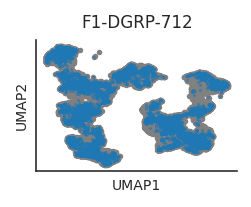

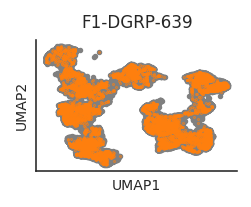

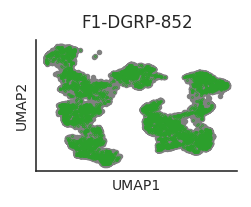

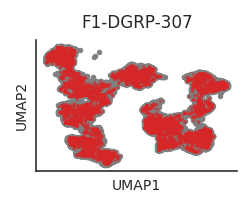

In [21]:
for exp_id in df['exp_id'].cat.categories:
    fig, ax = plt.subplots(figsize=(1.8, 1.2))
    ax.scatter(x='UMAP1', y='UMAP2', c='grey', data=df, s=3, label='%s' % i, rasterized=True,)
    ax.scatter(x='UMAP1', y='UMAP2', c=exp_id_colors[exp_id], data=df.query('exp_id == @exp_id'), s=.1, rasterized=True)
    ax.set(xlabel='UMAP1', ylabel='UMAP2', xticks=[], yticks=[], title='%s' % F1_IDS[exp_id])
    sns.despine()
    plt.show()
    save_panel(fig)
    plt.close()

## Number of cells

In [22]:
ncells = df.groupby(['exp_id', 'timepoint']).size().reset_index().rename({0: 'Cells'}, axis=1)

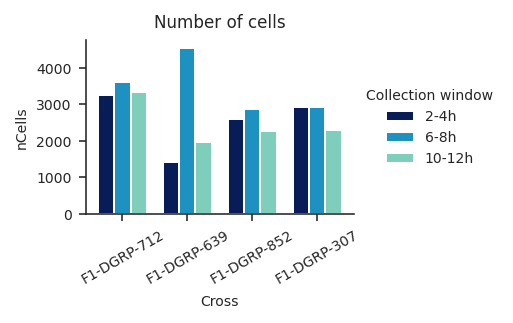

In [23]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))
barWidth = .25

r = np.arange(len(exp_ids))
rs = [r]
for i in range(len(timepoints)):
    rs.append([x + (i+1) * barWidth for x in r])

for i, t in enumerate(timepoints):
    label = t.replace('to', '-') + 'h'
    ax.bar(rs[i], height='Cells', width=barWidth, data=ncells.query('timepoint == @t'), label=label, color=timepoint_colors[t])
ax.set(
    title='Number of cells',
    xlabel='Cross', 
    ylabel='nCells', 
    xticks=[r + barWidth for r in range(len(exp_ids))])
ax.set_xticklabels(F1_IDS[exp_ids], rotation=30)
plt.legend(
    title='Collection window',
    loc='center left',
    bbox_to_anchor=(1, .5), 
    frameon=False)
sns.despine()

save_panel(fig)

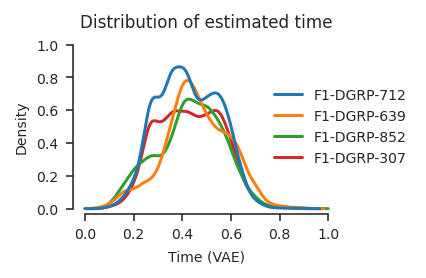

In [24]:
fig, ax = plt.subplots(figsize=(2.4, 1.6))

sns.kdeplot(
    x='Time (VAE)', 
    hue='Cross', 
    palette=exp_id_colors.to_dict(), 
    clip=(0, 1),
    data=df.rename({'time_vae': 'Time (VAE)', 'exp_id': 'Cross'}, axis=1),
    ax=ax)
ax.set(ylim=(-.03, 1.03), title='Distribution of estimated time')

labels = exp_ids
handles = [plt.Line2D([],[], color=exp_id_colors[i]) for i in labels]
labels = F1_IDS[labels].tolist()

plt.legend(
    handles=handles,
    labels=labels,
    #F1_IDS[exp_ids], 
    loc='center',
    bbox_to_anchor=(1, .5), 
    frameon=False)
sns.despine(trim=True)

save_panel(fig)